### Code for testing the generation of realistic wood samples

Consists of slightly altered code from: https://github.com/fgbossema/line_trajectory_simulations

In [2]:
# imports
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [3]:

def phantom_plank(phantom_size, angle = 0, p = 1, v0 = None, ring_width = 1, y1 = 0.222, y2 = 0.422, gaussian_blurr = 0): 
    '''
    Parameters
    ----------
    t : thickness of the plank (in mm)
    w : width of the plank (in mm) 
    l : length of the plank (in mm)
    vx_00 : x location of the left upper pixel relative to the pith (in mm)
    vy_00 : y location of the left upper pixel relative to the pith (in mm)
    vz_00 : z location of the left upper pixel relative to the pith (in mm)
    To have pith in middle of phantom: 
        v00 = (-1/2*phantom_size[1], 1/2*phantom_size[0],1/2*phantom_size[2])
    angle : tilt of the pith, in radians
    p : pixel size. The default is 1.
    y1 : lowest density value. The default is 0.222.
    y2 : highest density value. The default is 0.422. 
    
    Returns
    -------
    phantom : 3D plank phantom, with tree rings. 

    '''
    #If there are no explicit numbers for a,b,c,d,e, but a period given,
    #calculate the numbers a to e as ratio's of the period. 
    t, l, w = phantom_size
    if v0 is not None: 
        vx_00, vy_00, vz_00 = v0
    else: 
        #vx_00, vy_00, vz_00 = (-phantom_size[2],phantom_size[0]/2,0)
        vx_00, vy_00, vz_00 = (-1/2*phantom_size[1], 1/2*phantom_size[0],1/2*phantom_size[2])
    #period = np.ceil(ring_width/p)
    period = ring_width
    #period>0.5
    a = 0
    b = 0.2#4/10*period
    c = 1/2*period
    d = 1/2*period+0.2#(9/10)*period
    e = period
    
    
    
    m = np.int(np.ceil(t/p))
    n = np.int(np.ceil(w/p))
    o = np.int(np.ceil(l/p))
        
    phantom = np.zeros((m,n,o), dtype = 'float32')
    
    #If the tree is straight, every layer is the same. 
    if angle == 0:
        for i in range(m):
            for j in range(n):
                dist = distance_to_pith(i, j, 0, vx_00,vy_00, 0, 0, p)
                value = truncated_triangle(dist, y1, y2, a, b, c, d, e)
                phantom[i,j,:] = value
    
    #If the tree is at an angle, or the plank is cut at an angle, 
                #every layer is different. 
    else: 
        for i in range(m):
                for j in range(n):
                    for k in range(o):
                        dist = distance_to_pith(i, j, k, vx_00, vy_00, vz_00, angle, p)
                        value = truncated_triangle(dist, y1, y2, a, b, c, d, e)
                        phantom[i,j,k] = value
    
    # plt.imshow(phantom[:,:,0])
    # plt.title("First layer of generated phantom (Before adding G blur)")
    # plt.show()
    if gaussian_blurr>0: 
        for i in np.arange(phantom.shape[2]):
            phantom[:,:,i] = gaussian_filter(phantom[:,:,i],sigma = gaussian_blurr)
    
    return phantom

def distance_to_pith(r, c, lr, vx_00, vy_00, vz_00, angle, p):
    '''

    Parameters
    ----------
    r : rownumber
    c : columnnumber
    lr: layernumber (slice in z-direction, which is along the tree)
    vx_00 : x location of the left upper pixel relative to the pith in mm
    vy_00 : y location of the left upper pixel relative to the pith in mm
    vz_00 : z location of the left upper pixel relative to the pith in mm
    p : pixel size, optional, The default is 1.
    

    Returns
    -------
    distance from pith of tree to pixel

    '''
    vx = vx_00 + p*c
    vy = vy_00 - p*r
    vz = vz_00 - p*lr
    
    return np.sqrt(vx**2 + vy**2) + vz * np.arcsin(angle) 

def truncated_triangle(l, y1, y2, a, b, c, d, e):
    '''
    Parameters
    ----------
    l : distance to pith of tree 
    y1 : lowest function value
    y2 : highest function value
    a : start of period including two tree rings, one year: 
        a denser ring and a less dense ring, start of increasing slope
    b : stop of the increasing slope
    c : start of the decreasing slope
    d : stop of the decreasing slope
    e : end of period

    Returns
    -------
    Value for the pixel in the tree phantom, based on a truncated triangle 
    function. 

    '''
    l_mod = np.mod(l,e-a)
    
    if a <= l_mod  < b: 
        return np.abs((y2-y1)/(b-a)*(l_mod-a)+y1)
    elif b <= l_mod < c:
        return y2
    elif c <= l_mod < d:
        return np.abs(-(y2-y1)/(d-c)*(l_mod-c)+y2)
    elif d <= l_mod < e:
        return y1

### Phantom plank:
------------------
- **phantom_size**: Triple of (thickness, length, width) of wood sample (mm).
- **v0 = vx_00, vy_00, vz_00**: Locations of furthest away pixels from [pith](https://woodcarvingillustrated.com/blog/2017/09/18/anatomy-of-wood/#:~:text=Pith%3A%20At%20the%20very%20center,wood%20that%20include%20the%20pith.).
    - - Default values: (-phantom_size[2],phantom_size[0]/2,0)
- **angle**: Tilt of *pith*.
- **p**: Pixel size (default=1)
- **y1, y2**: Lowest and highest values of attenuation coefficient respectively.
- **ring_width**: The width of concentric tree rings (assuming this is measured in pixels?) default is 1.
- **gaussian_blur**: *blurs* image. default is 0.

#### Determination of parameter values
----------------------
- **phantom_size**:
    - Test data given is 5000x5000 pixels, with each pixel representing 1mm (image is 500mmx500mm). Thickness is somewhat arbitrary. will set parameter as (500, 500, 500) for now.
- **vx_00, vy_00, vz_00**:
    - We want pith in the centre, as we will be examining the entire cross-section: (1/2 length, 1/2 thickness, 1/2 width)
- **angle**: 
    - Assume that log will be perfectly centred for now: 0 rad. (default)
- **y1, y2**: Highest and lowest attenuation coefficients for wood (will just work with 0.222 and 0.422 for now)
- **gaussian_blur**: Pretty arbitrary. Will just see what looks best. When ~ 4 seems to get very blurry. 2.5 seems to best for now.

rest default.

Testing below. Very confused.

In [35]:
# Parameters
phantom_size = (500, 500, 500) # t - y axis , l - z axis (defines slice), w - x axis
v0 = ((-1/2)*phantom_size[1], (1/2)*phantom_size[0],(1/2)*phantom_size[2])
ring_width = 10.0
angle = np.deg2rad(0.0)
pix_size = 1
blur = 2.5

P = phantom_plank(phantom_size, angle = angle, p = pix_size, ring_width = ring_width, gaussian_blurr=blur).transpose([0,2,1])
# Unsure as to why the phantom has to be transposed? 
# Phantom has essentially been rotated 90 degrees (clockwise?)
print(f"Shape of Phantom data: {P.shape}")

C:\Users\miles\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\miles\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

Shape of Phantom data: (500, 500, 500)


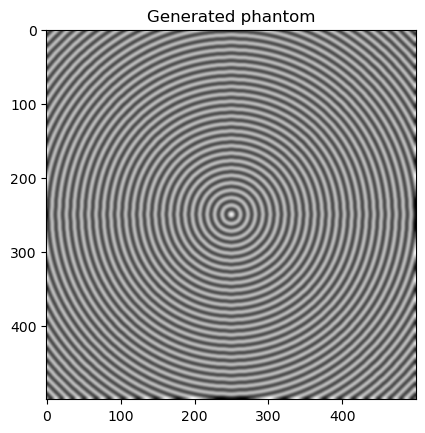

In [36]:
# displaying plank
plt.imshow(P[:,0,:], cmap="gray")
plt.title(f"Generated phantom")
plt.show()

Current assumptions about the phantom size parameter:
- thickness: Represents y-axis in image
- length: represents z-axis, defines current slice
- width: x axis

Seems to follow this, but position of pith changes? Just easiest to make all dimensions equal.

pix_size:
- Was thinking that increase image size by factor of 10, and increasing pixel size by factor 10 should maintain resolution - does not.
    - Probably due to ring size needing to increase? Yes

Comparing the two images (first slices)

Attempting to recreate what was generated using test.py

In [ ]:
ringwidths = np.array([1.0])
angles = np.array([0])
pix_size = 0.05
phantom_size = (30,30,30)
P = phantom_plank(phantom_size, angle = np.deg2rad(i), p = pix_size, ring_width = ring_width, gaussian_blurr=blur).transpose([0,2,1])